# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
Необходимо построить модель, которая умеет её определять. В распоряжении имеются данные о технических характеристиках, комплектации и ценах других автомобилей.

Во время исследования необходимо испробовать как обычные модели, так и модели с градиентным бустингом.


Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

**Тип задачи:** регрессия.

**Примечания:**
* Для оценки качества моделей необходимо применять метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.
* Необходимо использовать библиотеку LightGBM и её средствами построить модели градиентного бустинга.


## Описание данных

**Признаки:**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак:**
* `Price` — цена (евро)

## Импорты и настройки

In [1]:
# Импорты
import pandas as pd
import numpy as np
import lightgbm as lgb
import random
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Настройки
pd.set_option('display.float_format', '{:.2f}'.format)
np.random.seed(777)

## План работы

* Загрузка и первоначальный осмотр данных
* Изучение данных
* Подготовка данных к обучению
* Обучение моделей и подбор лучших гиперпараметров
* Результаты обучения и выбор лучшей модели
* Итоговое тестирование
* Общие выводы

## Загрузка и первоначальный осмотр данных

Загрузка данных:

In [3]:
try:
    original_df = pd.read_csv('/datasets/autos.csv')
    display('Данные из практикума загружены.')
except:
    original_df = pd.read_csv('datasets/autos.csv')
    display('Локальные данные загружены.')

original_df.name = 'original_df'

'Локальные данные загружены.'

Первоначальный осмотр данных:

In [4]:
display("Голова:", original_df.head())
display("Хвост:", original_df.tail())
display("Инфо:", original_df.info())

'Голова:'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


'Хвост:'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

'Инфо:'

None

Посмотрим на долю пропусков в данных:

In [5]:
original_df.isna().mean() * 100

DateCrawled          0.00
Price                0.00
VehicleType         10.58
RegistrationYear     0.00
Gearbox              5.60
Power                0.00
Model                5.56
Kilometer            0.00
RegistrationMonth    0.00
FuelType             9.28
Brand                0.00
Repaired            20.08
DateCreated          0.00
NumberOfPictures     0.00
PostalCode           0.00
LastSeen             0.00
dtype: float64

Визуализируем пропуски:

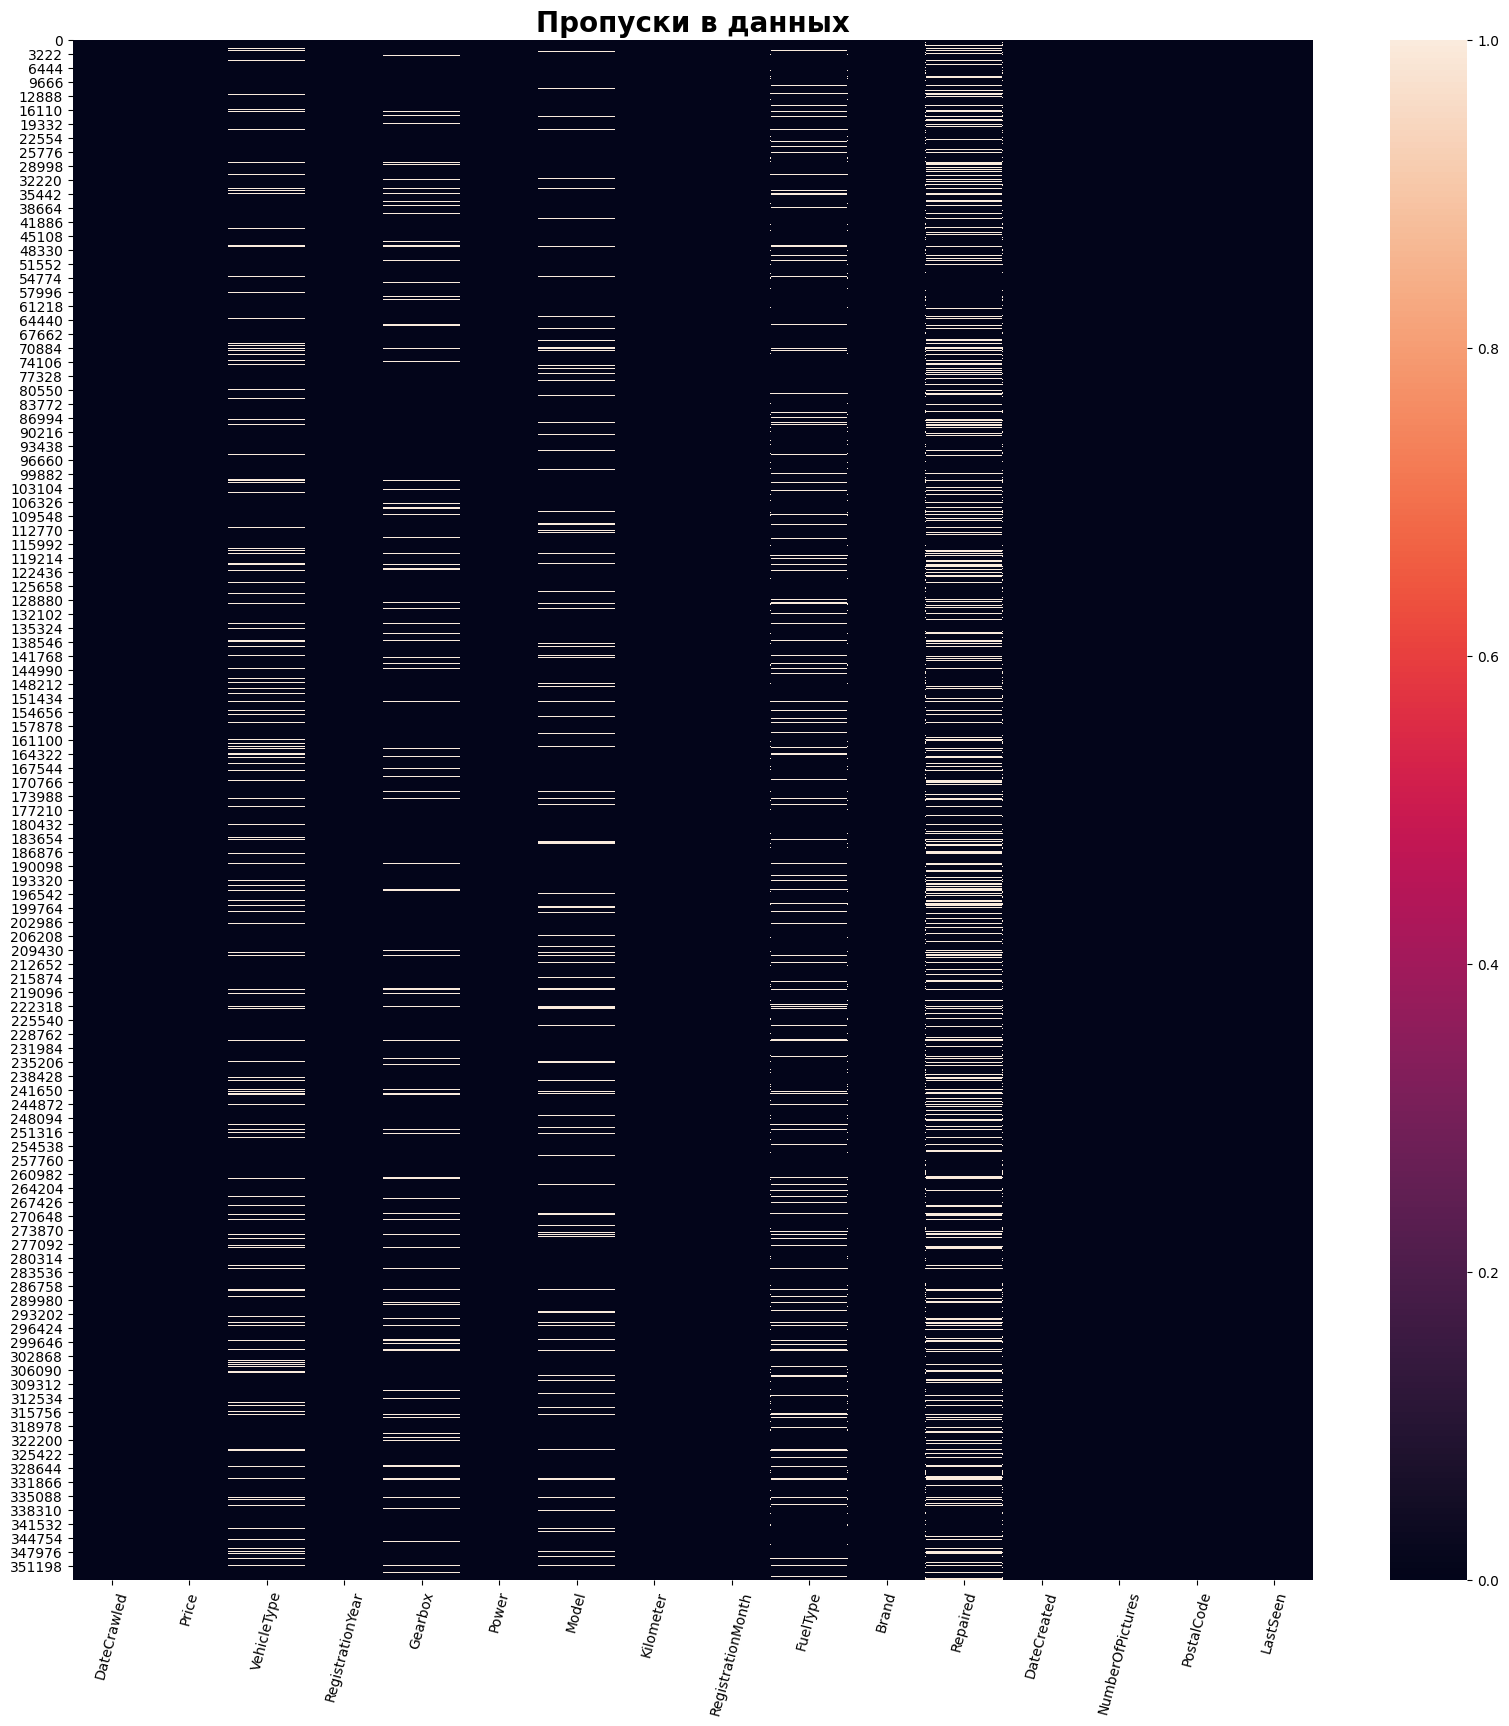

In [6]:
def na_visualizator(df):
    i = 0
    step = 30
    while i < df.shape[1]:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_title('Пропуски в данных', fontsize=20, weight='bold')
        ax.set_xlabel('Столбец', fontsize=15)
        ax.set_ylabel('Индекс', fontsize=15)
        sns.heatmap(df.iloc[:, i:i + step].sort_index().isna(), ax=ax);
        ax.tick_params(axis='x', labelsize=10, rotation=75)
        ax.tick_params(axis='y', labelsize=10)
        plt.show
        i += step

na_visualizator(original_df)

Посмотрим на наличие прямых дублей:

In [7]:
display("Количество прямых дублей:", original_df.duplicated().sum())
original_df[original_df.duplicated(keep=False)].sort_values('RegistrationYear')

'Количество прямых дублей:'

4

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


Посмотрим на период выгруженных объявлений:

In [8]:
display(original_df['DateCreated'].min())
display(original_df['DateCreated'].max())

'2014-03-10 00:00:00'

'2016-04-07 00:00:00'

**Выводы:**
* Более 350 тыс. строк и 16 столбцов.
* Анкеты за период с 2014 по 2016 гг.
* По 5 столбцам имеются пропуски в данных (от 5 до 20%, визуально распределены равномерно по данным).
* Не все типы определились корректно. Требуется их переименовать и обработать типы.
* Есть 4 прямых дубликата, от которых нужно избравиться. Так же стоит провести поиск непрямых дубликатов.

## Изучение данных

Создадим рабочую копию датафрейма:

In [9]:
df = original_df.copy()

Приведем в порядок названия столбцов:

In [10]:
df.columns = ['date_crawled',
              'price',
              'vehicle_type',
              'registration_year',
              'gearbox',
              'power',
              'model',
              'kilometer',
              'registration_month',
              'fuel_type',
              'brand',
              'repaired',
              'date_created',
              'number_of_pictures',
              'postal_code',
              'last_seen']

Удалим прямые дубликаты:


In [11]:
display(df.shape)
df.drop_duplicates(inplace=True)
display(df.shape)

(354369, 16)

(354365, 16)

Избавимся от столбцов, которые по природе не могут относиться к прогнозированию стоимости автомобиля:
* **Дата скачивания анкеты** - никак не относится к стоимости реализации авто. Более того, анкета может быть скачана уже после продажи авто.
* **Дата создания анкеты** - не ясно как это может помочь спрогнозировать стоимость авто.
* **Почтовый индекс владельца** - косвенно может указывать на регион продажи авто, что может теоретически влиять на цену продажи, однако этот показатель скорее мусорный, т.к. он слишком изменчивый (может быть разным даже в пределах одного города), напрямую не связан с фактом и местом продажи.
* **Дата последней активности пользователя** - так же может быть после продажи авто. В прогнозировании этих данных быть не должно.

In [12]:
current_columns = ['date_crawled', 'date_created', 'postal_code', 'last_seen']
display(df.shape)
df.drop(columns=current_columns, inplace=True)
display(df.shape)

(354365, 16)

(354365, 12)

Изучим столбец model на наличие непрямых дубликатов:

In [13]:
df['model'].value_counts(dropna=False).sort_index()

100          417
145           49
147          572
156          629
159          212
           ...  
yeti         174
ypsilon      209
z_reihe      717
zafira      3044
NaN        19705
Name: model, Length: 251, dtype: int64

Обнаружен непрямой дубль. Заменим rangerover на range_rover:

In [14]:
display(df['model'].value_counts(dropna=False).shape[0])
df['model'].replace('rangerover', 'range_rover', inplace=True)
df['model'].value_counts(dropna=False).shape[0]

251

250

Посмотрим на виды топлива автомобилей:

In [15]:
df['fuel_type'].value_counts(dropna=False).sort_index()

cng            565
electric        90
gasoline     98719
hybrid         233
lpg           5310
other          204
petrol      216349
NaN          32895
Name: fuel_type, dtype: int64

Объединим категории gasoline и petrol (название одного и того же типа топлива в разных регионах):

In [16]:
display(df['fuel_type'].value_counts(dropna=False).shape[0])
df['fuel_type'].replace('petrol', 'gasoline', inplace=True)
df['fuel_type'].value_counts(dropna=False).shape[0]

8

7

Сделаем визуализацию для количественных переменных:

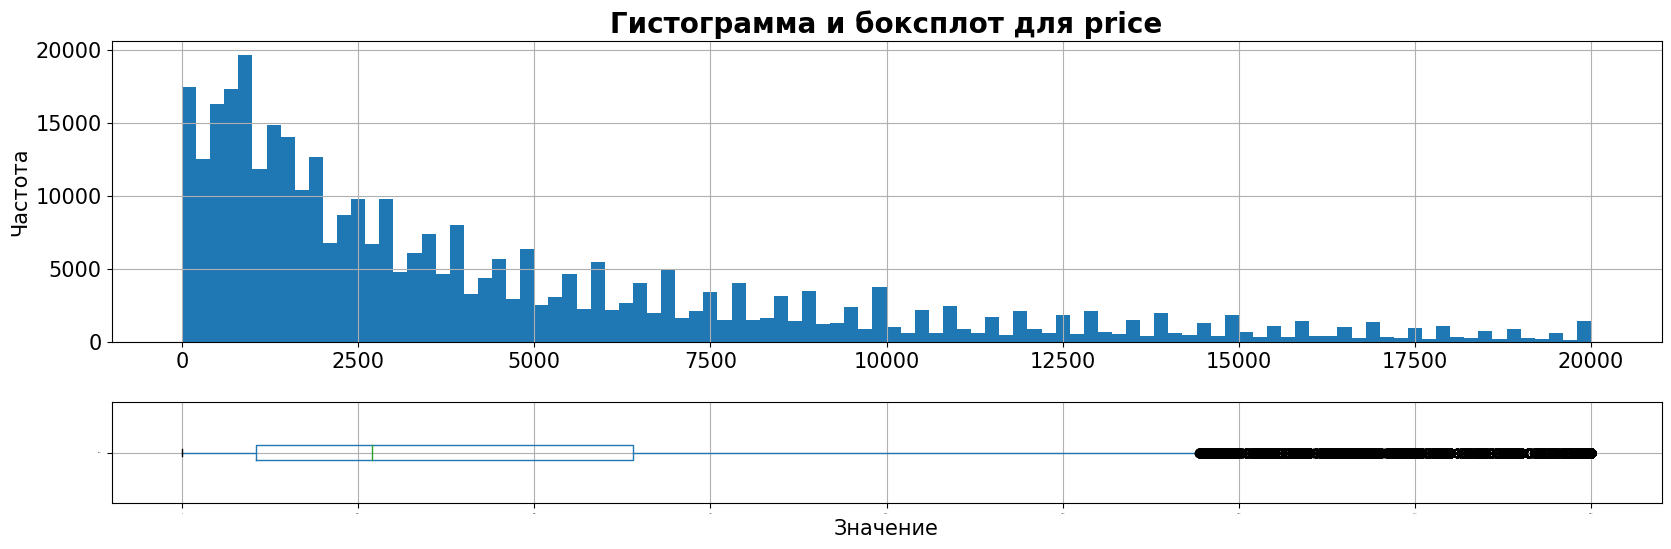

'Количество уникальных значений в столбце price: 3731'

'Количество пропусков в столбце price: 0.00 (0.00%)'

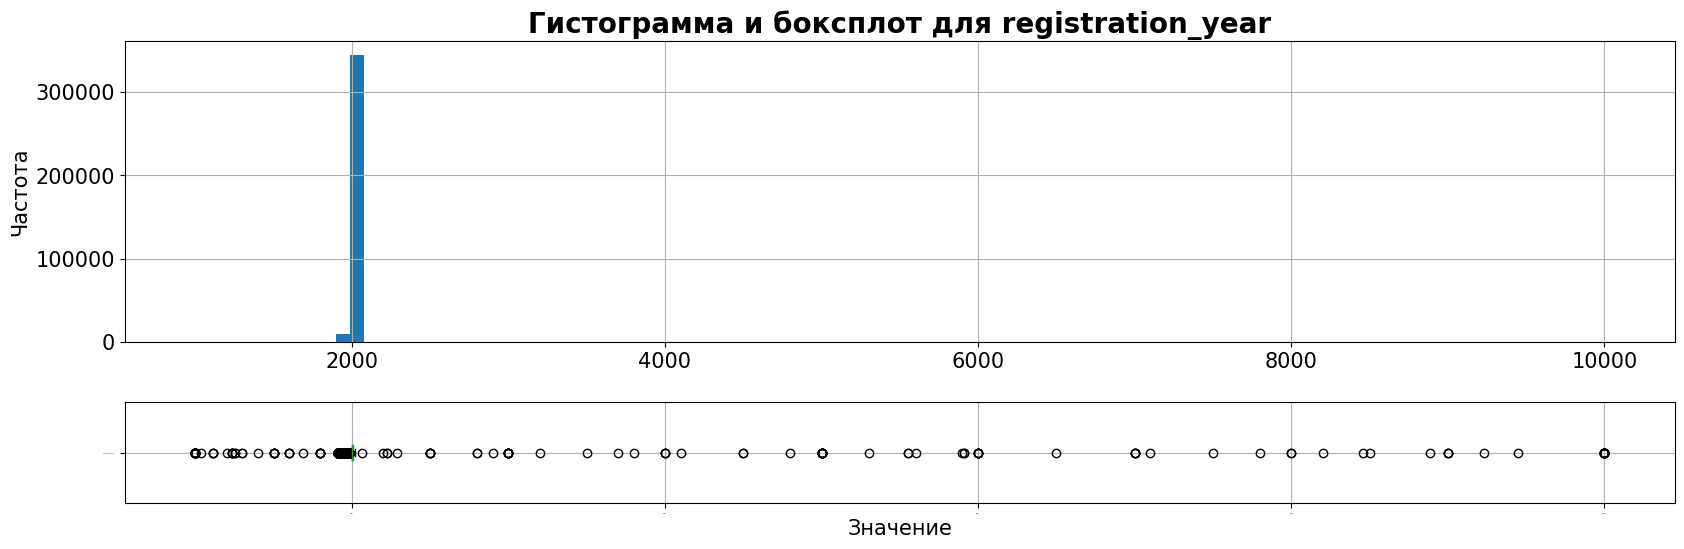

'Количество уникальных значений в столбце registration_year: 151'

'Количество пропусков в столбце registration_year: 0.00 (0.00%)'

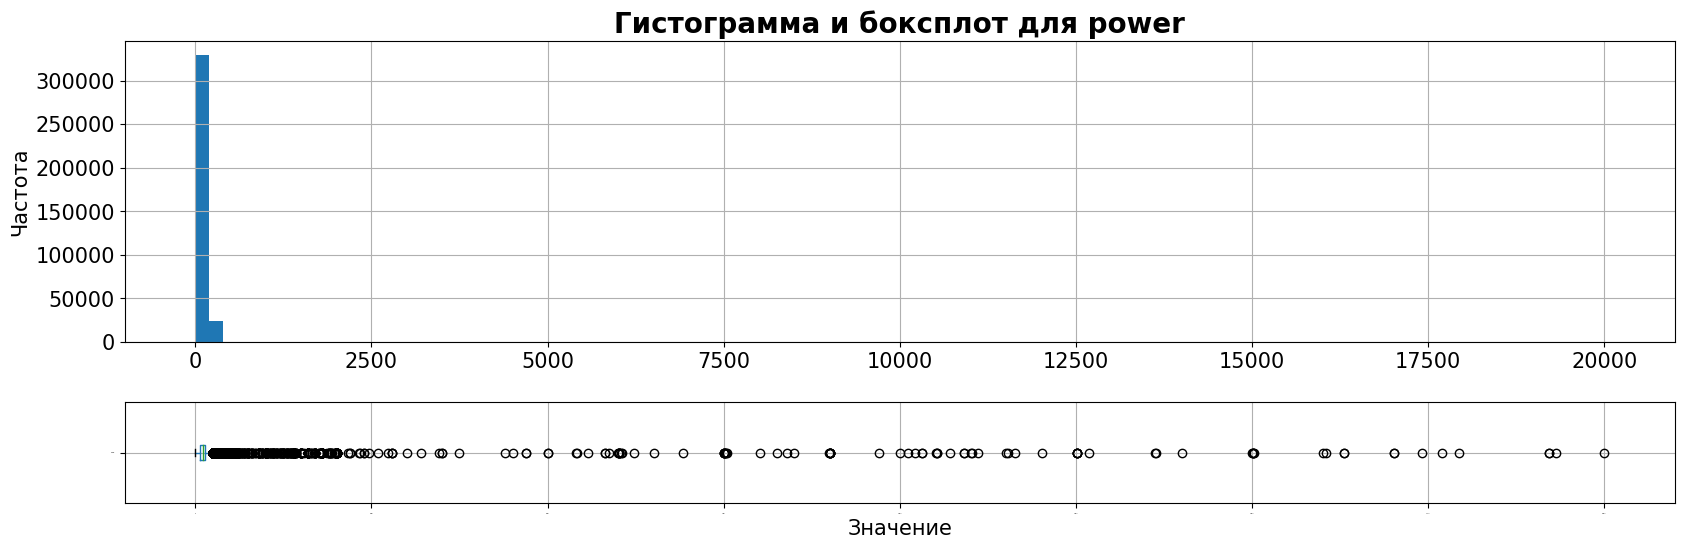

'Количество уникальных значений в столбце power: 712'

'Количество пропусков в столбце power: 0.00 (0.00%)'

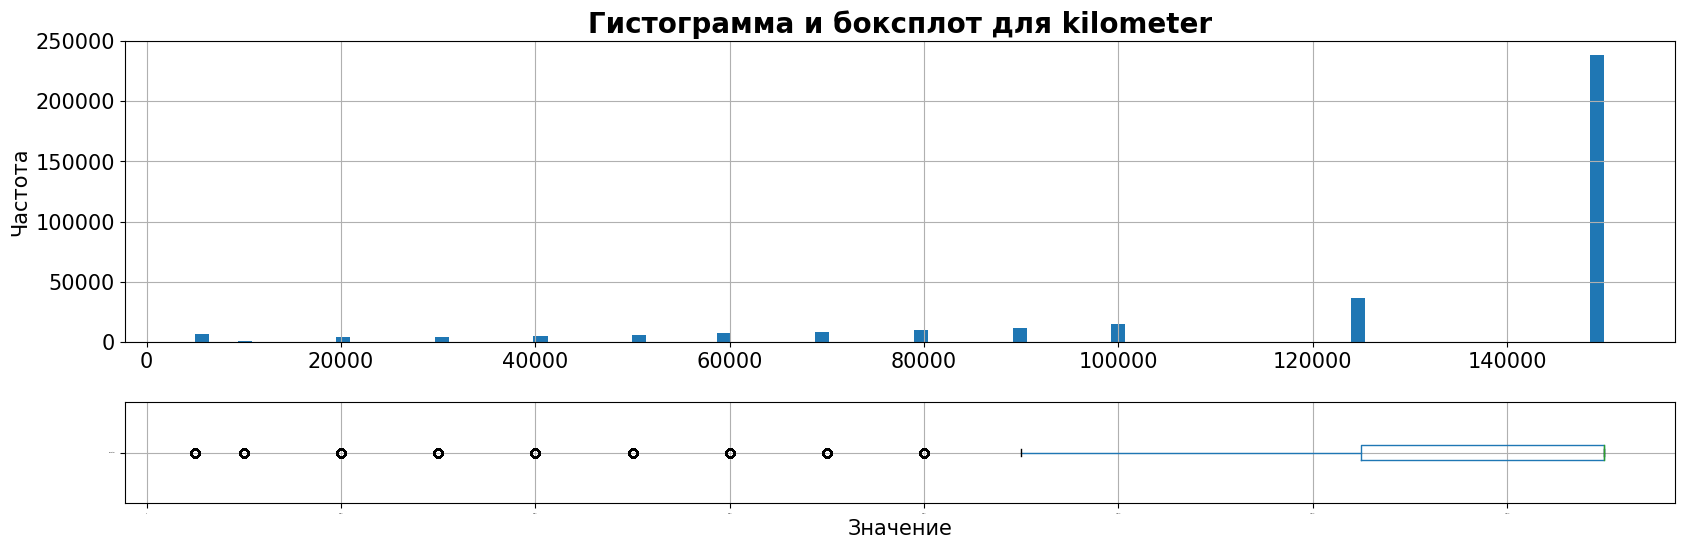

'Количество уникальных значений в столбце kilometer: 13'

'Количество пропусков в столбце kilometer: 0.00 (0.00%)'

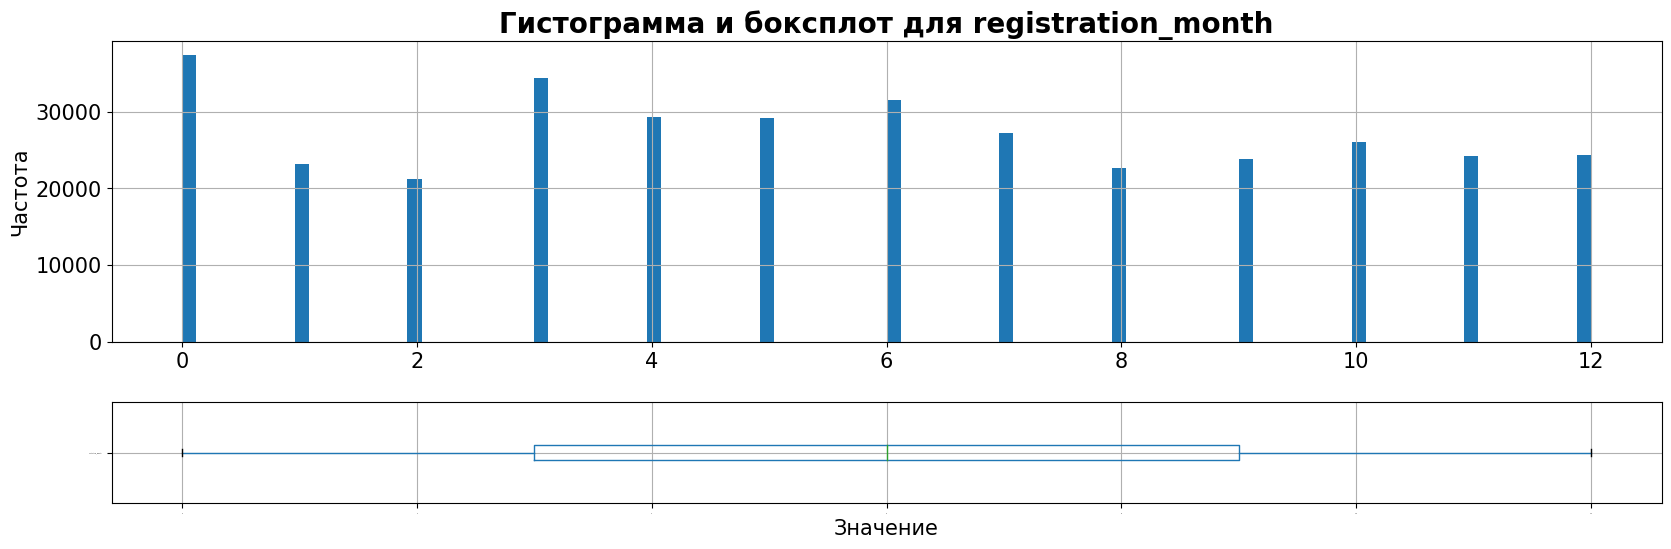

'Количество уникальных значений в столбце registration_month: 13'

'Количество пропусков в столбце registration_month: 0.00 (0.00%)'

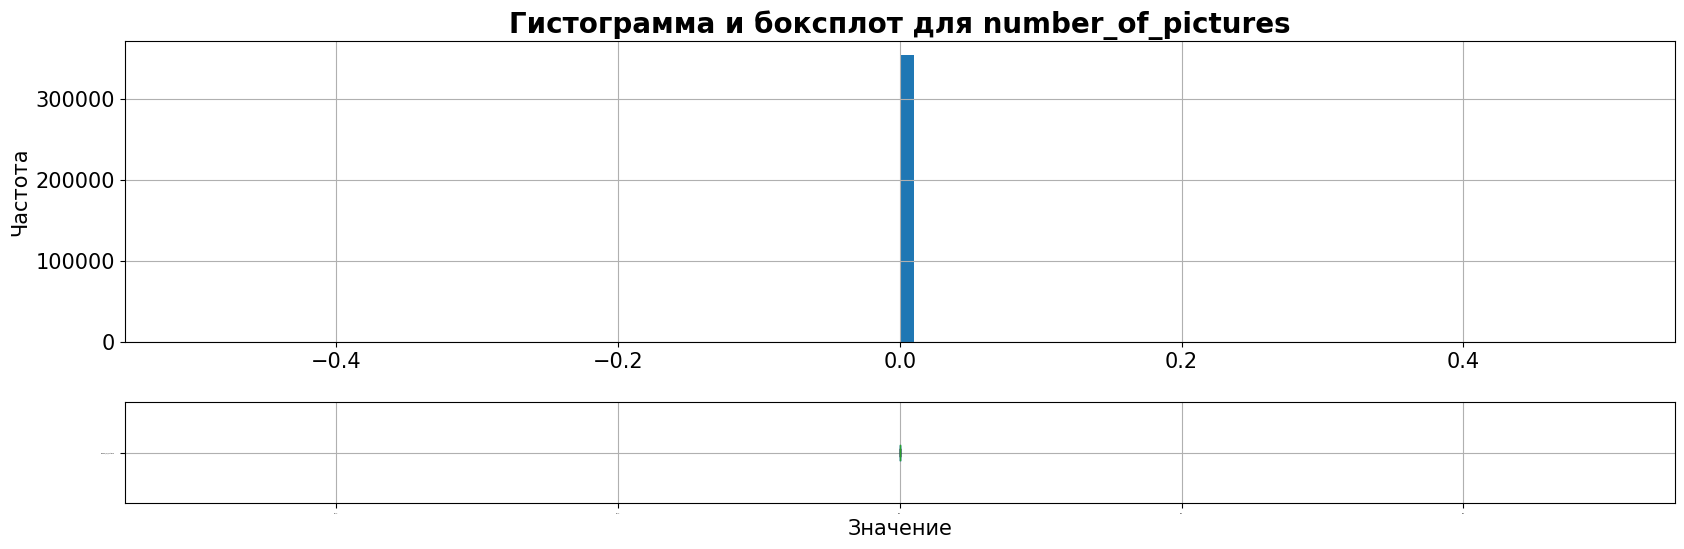

'Количество уникальных значений в столбце number_of_pictures: 1'

'Количество пропусков в столбце number_of_pictures: 0.00 (0.00%)'

In [17]:
def hist_boxplot_visualizator(df):
    for column in df.columns:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 6), gridspec_kw={'height_ratios': [3, 1]})
        df.hist(column=column, bins=100, ax=ax1)
        df.boxplot(column=column, vert=False, ax=ax2)
        ax1.set_title(f'Гистограмма и боксплот для {column}', fontsize=20, weight='bold')
        ax1.set_ylabel('Частота', fontsize=15)
        ax1.tick_params(axis='both', labelsize=15)
        ax2.set_xlabel('Значение', fontsize=15)
        ax2.tick_params(axis='both', labelsize=0)
        plt.show()
        display(f'Количество уникальных значений в столбце {column}: {df[column].value_counts().shape[0]}')
        display(f'Количество пропусков в столбце {column}: {df[column].isna().sum():.2f} ({df[column].isna().mean():.2%})')

hist_boxplot_visualizator(df.select_dtypes(include='int64'))

С `registration_year` что-то не так. Первый массовый автомобиль был выпущен в 1908 году. Так же не должно быть ситуации, когда год регистрации автомобиля больше, чем год скачивания анкеты.

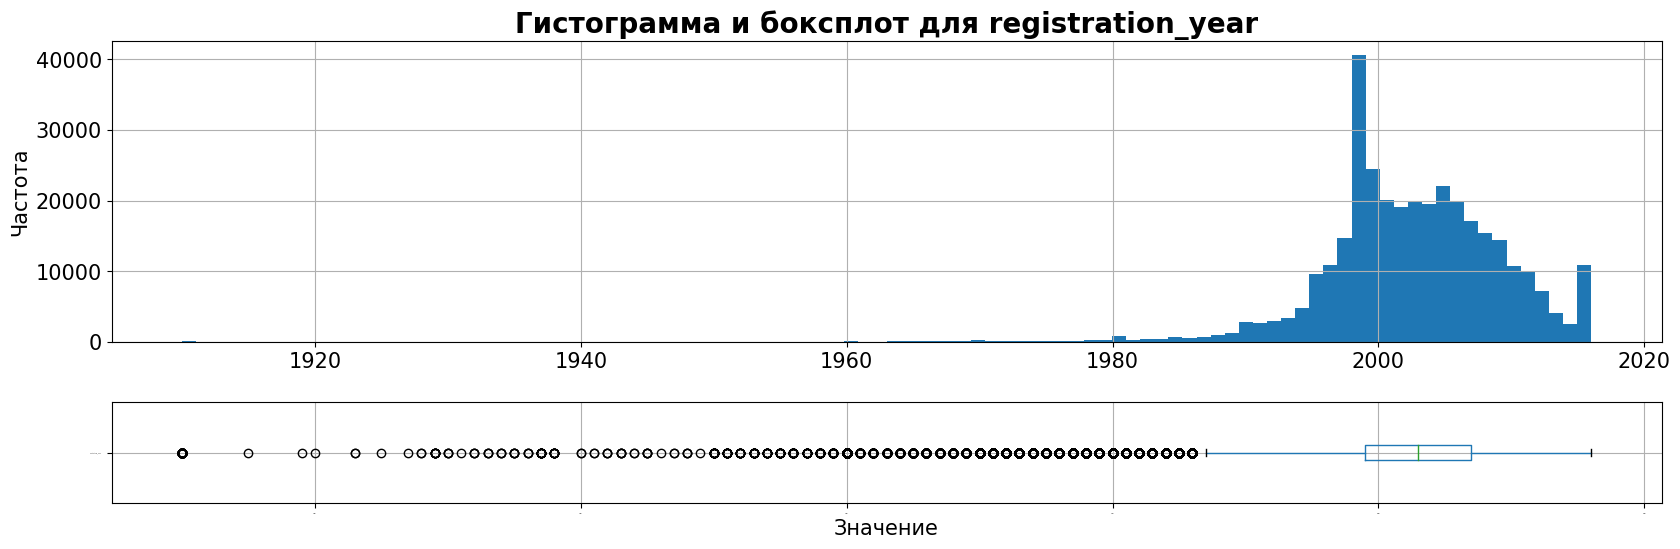

'Количество уникальных значений в столбце registration_year: 95'

'Количество пропусков в столбце registration_year: 14596.00 (4.12%)'

In [18]:
# Получим список неверных значений.
date_crawled = pd.to_datetime(original_df.drop_duplicates()['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
year_crawled = date_crawled.dt.year
values_to_na = df[(df['registration_year'] < 1908) | (df['registration_year'] > year_crawled)]['registration_year'].unique()
# Сделаем замену на na по списку.
df['registration_year'].replace(values_to_na, float('nan'), inplace=True)
# Посмотрим на результат
hist_boxplot_visualizator(pd.DataFrame(df['registration_year']))

Столбец `power` тоже выглядит не очень хорошо. Самые мощные авто в мире по мощности не превышают 1600 л.с.Для целей исследования (прогнозирование авто массового сегмента) я бы ограничился 500 л.с. Для эксплюзивных дорогих авто наш механизм всё равно не будет иметь смысла, т.к. тут в любом случае будет требоваться оценка вручную. Так же срежем значения меньше 10 лошадинных сил.

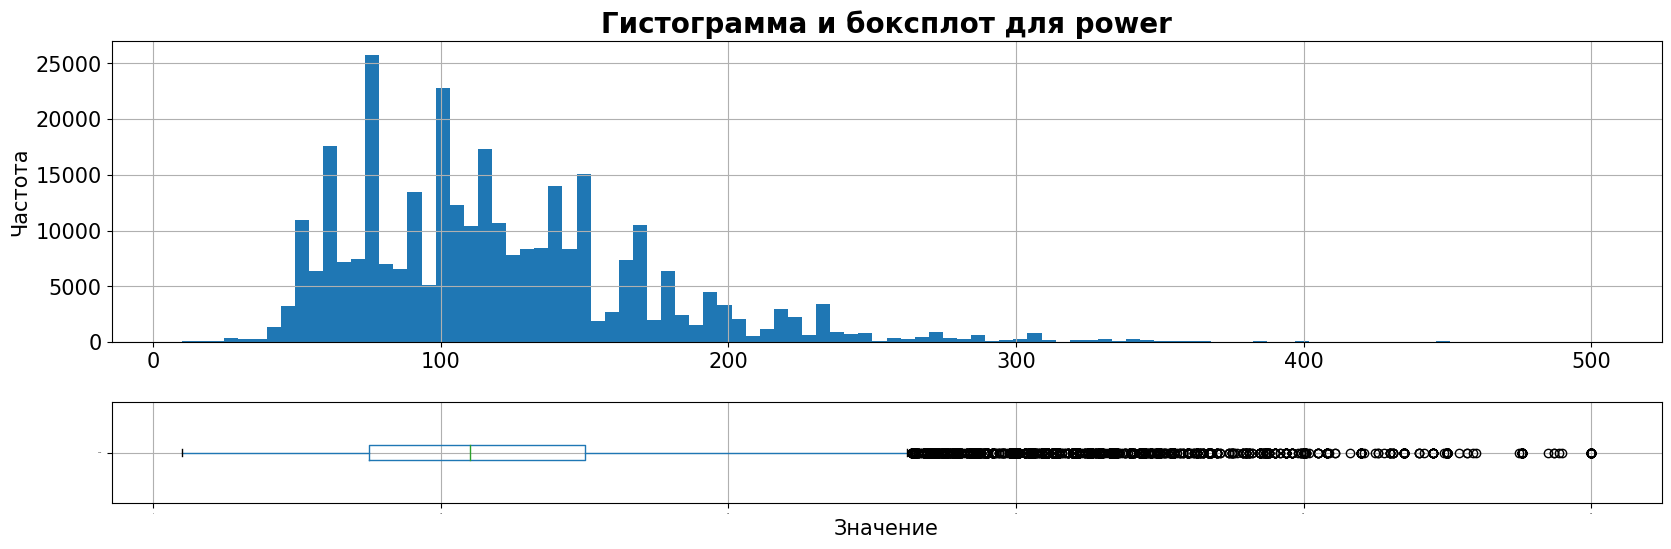

'Количество уникальных значений в столбце power: 403'

'Количество пропусков в столбце power: 40904.00 (11.54%)'

In [19]:
df.loc[df['power'] > 500, 'power'] = float('nan')
df.loc[df['power'] < 10, 'power'] = float('nan')
hist_boxplot_visualizator(pd.DataFrame(df['power']))

Заменим 0 месяц регистрации на na. Скорее всего - это поле не было корректно заполнено.

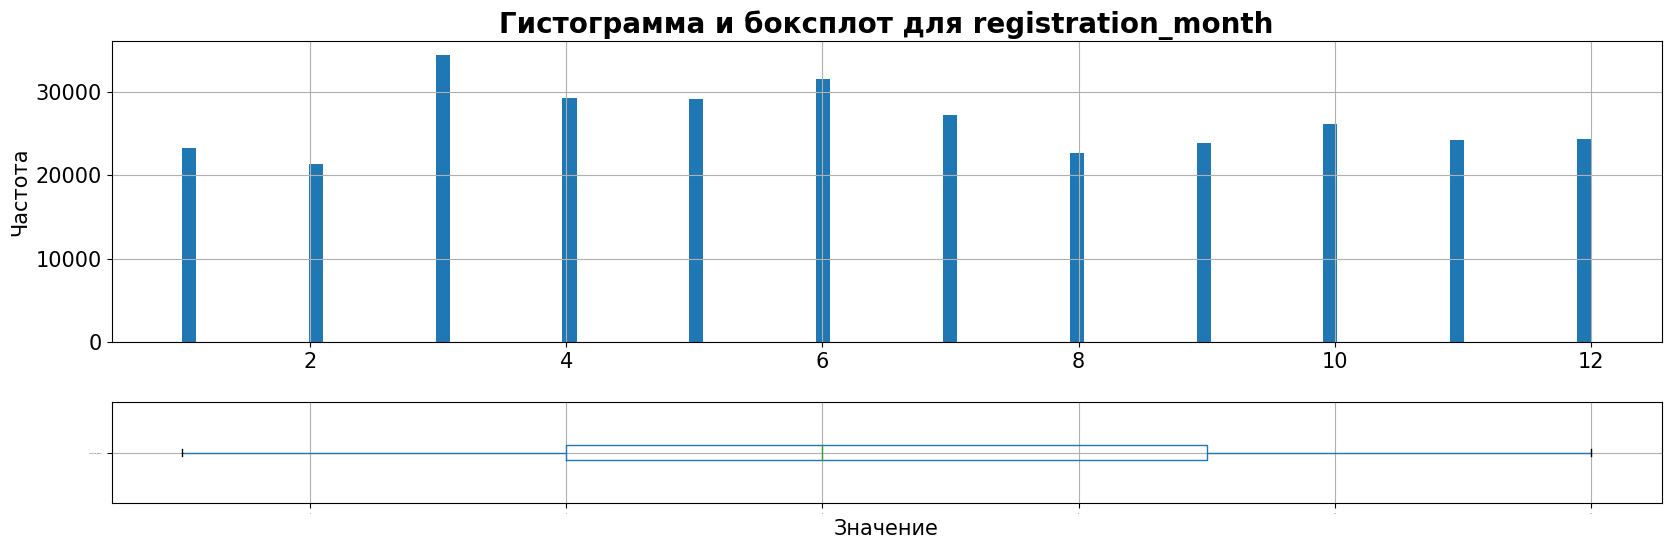

'Количество уникальных значений в столбце registration_month: 12'

'Количество пропусков в столбце registration_month: 37352.00 (10.54%)'

In [20]:
df.loc[df['registration_month'] == 0, ['registration_month']] = float('nan')
hist_boxplot_visualizator(pd.DataFrame(df['registration_month']))

Столбец `number_of_pictures` удалим - он неинформативен:

In [21]:
display(df.shape)
df.drop(columns=['number_of_pictures'], inplace=True)
display(df.shape)

(354365, 12)

(354365, 11)

Внимательнее посмотрим на целевой признак в ультрадешевом диапазоне (до 100 евро):

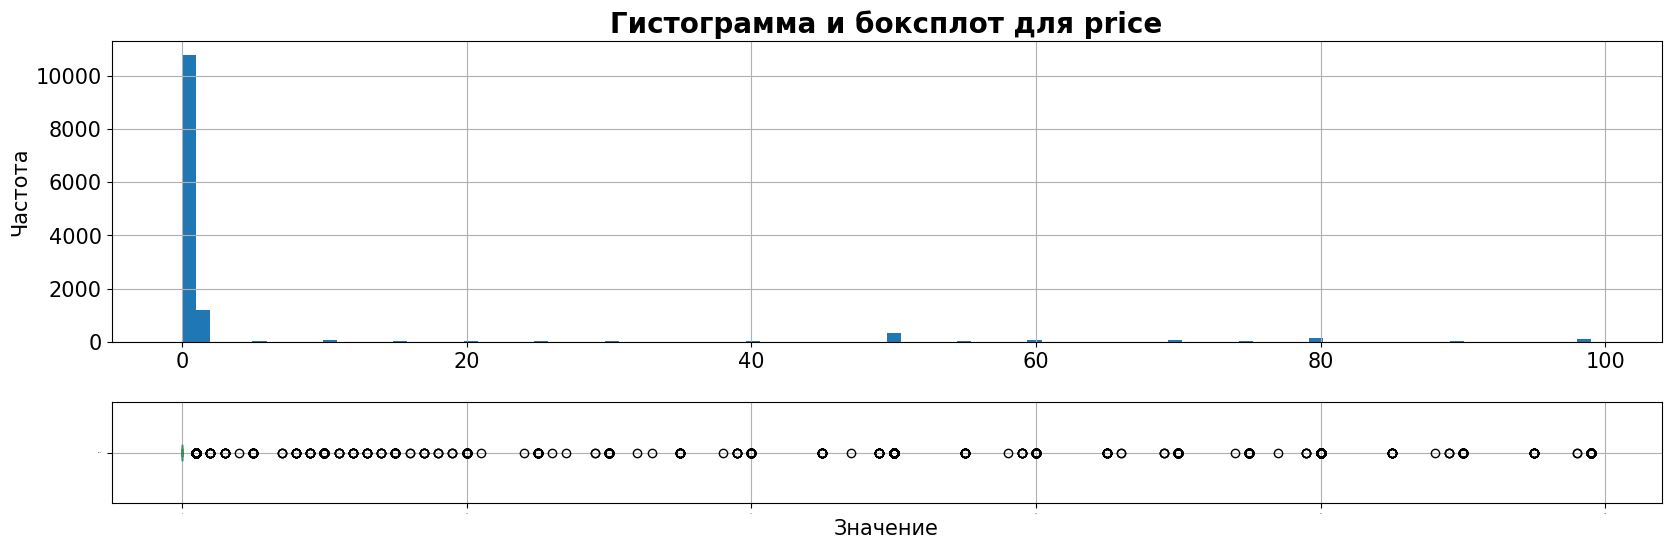

'Количество уникальных значений в столбце price: 57'

'Количество пропусков в столбце price: 0.00 (0.00%)'

In [22]:
limit = 100
hist_boxplot_visualizator(pd.DataFrame(df[df['price'] < limit]['price']))

Посмотрим на пробег этих автомобилей:

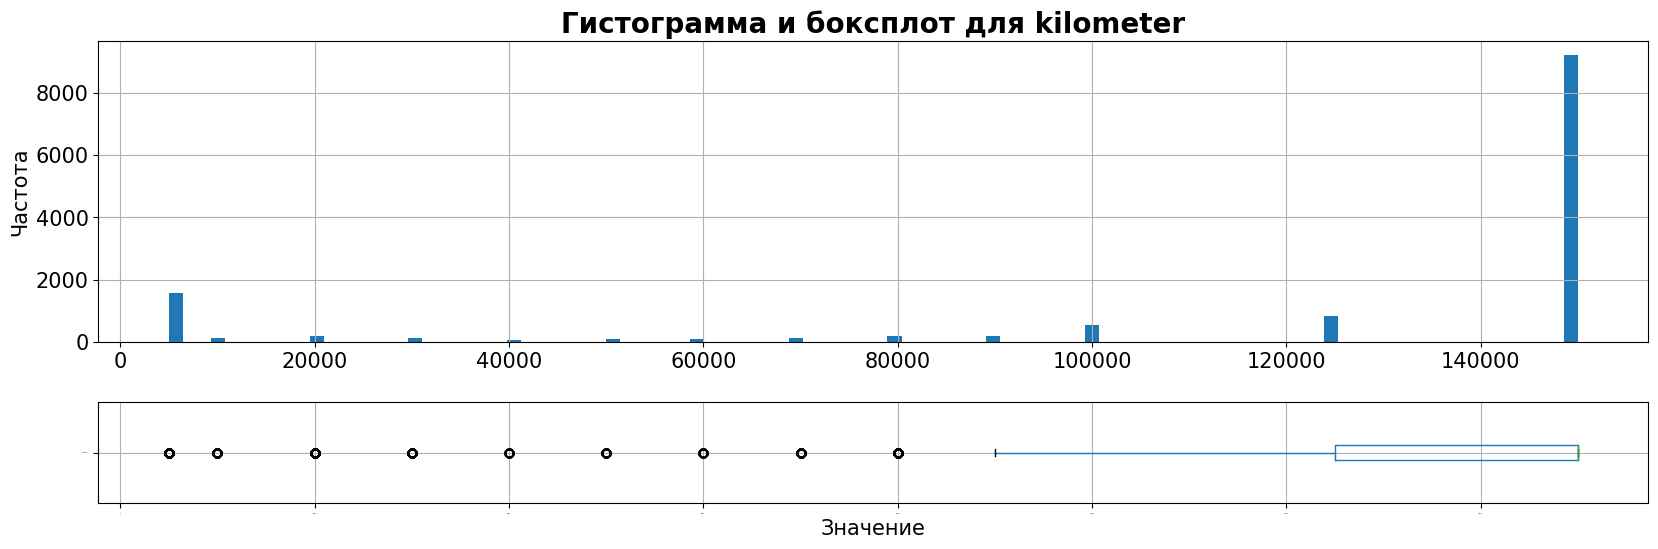

'Количество уникальных значений в столбце kilometer: 13'

'Количество пропусков в столбце kilometer: 0.00 (0.00%)'

150000    9206
5000      1558
125000     832
100000     547
90000      197
20000      179
80000      179
70000      127
30000      125
10000      121
50000       93
60000       87
40000       63
Name: kilometer, dtype: int64

In [23]:
hist_boxplot_visualizator(pd.DataFrame(df[df['price'] < limit]['kilometer']))
df[df['price'] < limit]['kilometer'].value_counts()

Более 10 тыс. авто продавались по символической цене 0-1 евро. Однозначно назвать эти значения ошибочными сложно. Как видно по пробегу этих авто и авто ценой до 100 евро - большая часть машин уже отъездила своё. Вероятно, существует категория продавцов, которые готовы отдать свой автомобиль за бесценок под разбор, чтобы не нести расходы на утилизацию.

Сделаем визуализацию для категориальных столбцов:

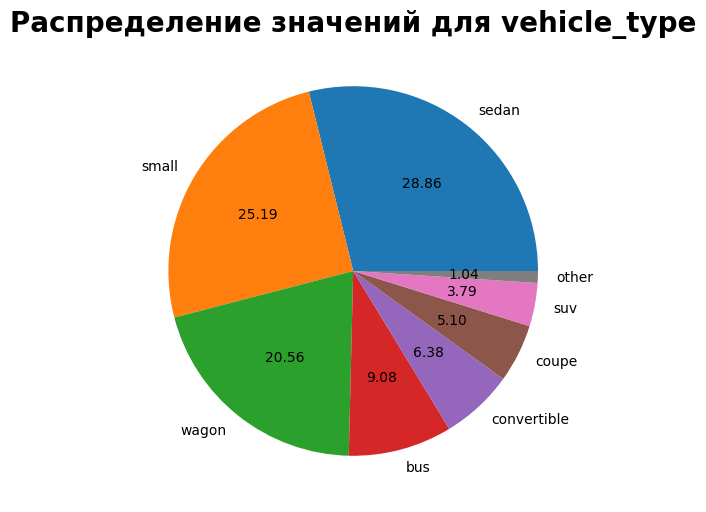

'Количество уникальных значений в столбце vehicle_type: 8'

'Количество пропусков в столбце vehicle_type: 37490.00 (10.58%)'

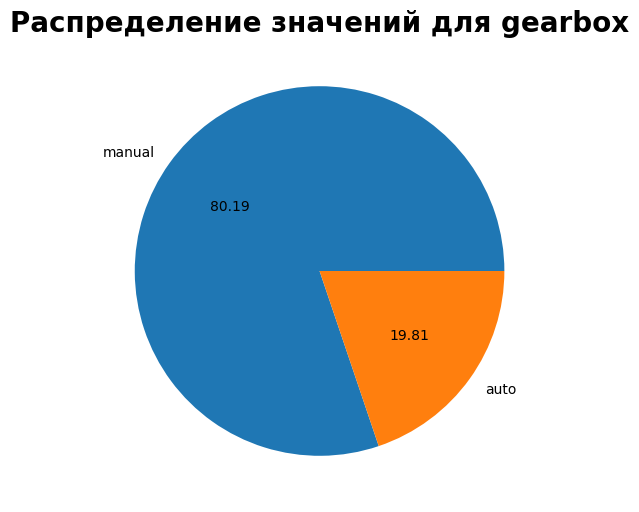

'Количество уникальных значений в столбце gearbox: 2'

'Количество пропусков в столбце gearbox: 19833.00 (5.60%)'

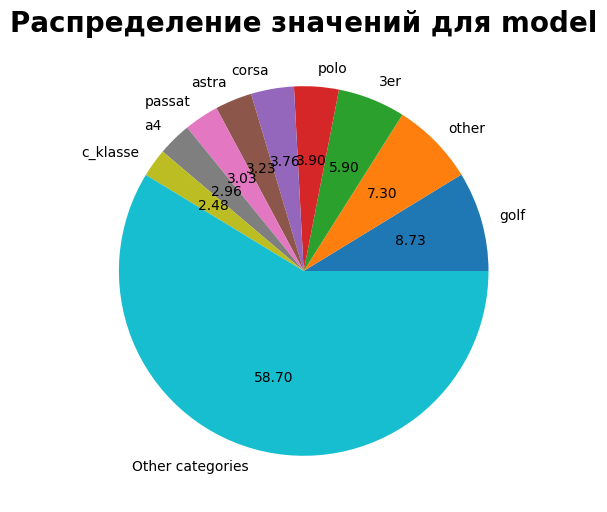

'Количество уникальных значений в столбце model: 249'

'Количество пропусков в столбце model: 19705.00 (5.56%)'

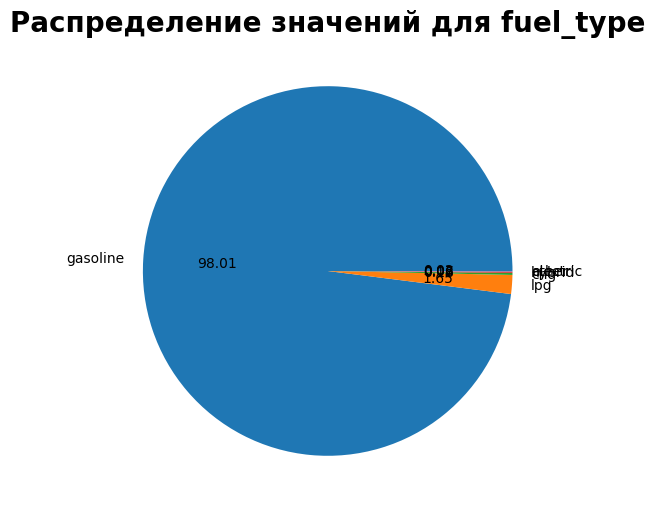

'Количество уникальных значений в столбце fuel_type: 6'

'Количество пропусков в столбце fuel_type: 32895.00 (9.28%)'

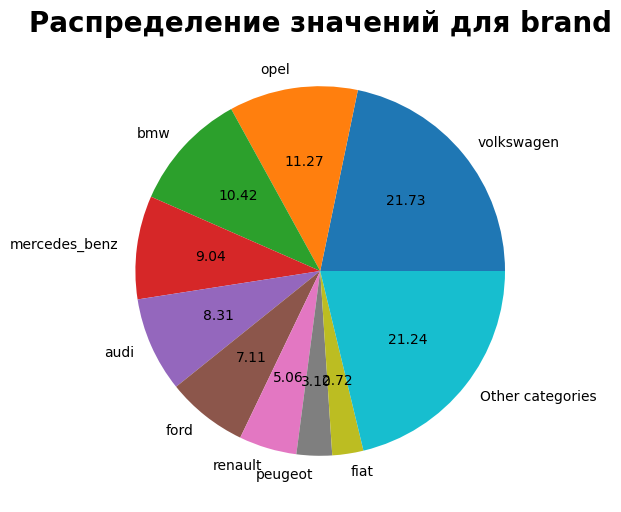

'Количество уникальных значений в столбце brand: 40'

'Количество пропусков в столбце brand: 0.00 (0.00%)'

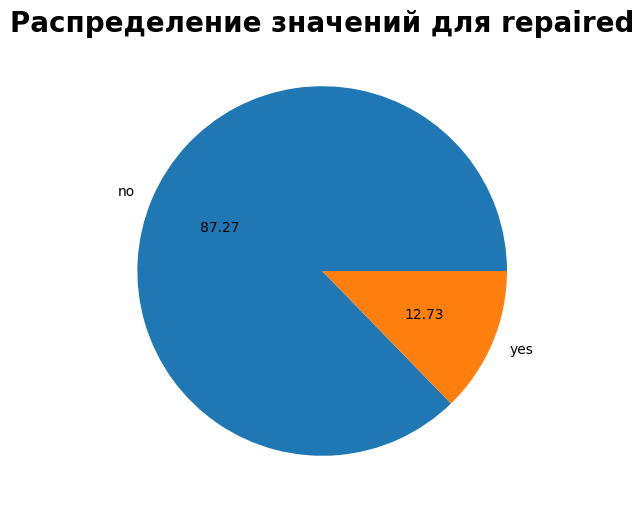

'Количество уникальных значений в столбце repaired: 2'

'Количество пропусков в столбце repaired: 71154.00 (20.08%)'

In [24]:
def pie_vsualizator(df):
    for column in df.columns:
        num_or_pieces = 10
        vc_for_data = df[column].value_counts()

        # Группировка в other при необходимости
        if vc_for_data.shape[0] > num_or_pieces:
            data_to_display = vc_for_data.iloc[:num_or_pieces-1]
            data_to_display['Other categories'] = vc_for_data.iloc[num_or_pieces-1:].sum()
        else:
            data_to_display = vc_for_data

        fig, ax = plt.subplots(figsize = (20, 6))
        data_to_display.plot(kind='pie', ax=ax, autopct='%.2f')
        ax.set_title(f'Распределение значений для {column}', fontsize=20, weight='bold')
        ax.set_ylabel('', fontsize=15)
        ax.tick_params(axis='both', labelsize=15)
        plt.show()
        display(f'Количество уникальных значений в столбце {column}: {df[column].value_counts().shape[0]}')
        display(f'Количество пропусков в столбце {column}: {df[column].isna().sum():.2f} ({df[column].isna().mean():.2%})')


pie_vsualizator(df.select_dtypes(include='object'))

**Выводы:**
* Удалены 4 прямых дубликата из данных.
* Удален ряд неинформативных для работы столбцов (даты скачивания и создания анкеты, почтовый индекс, время посещения и количество фотографий).
* Обнаружены непрямые дубликаты в столбце `model`. Значение rangerover заменено на range_rover. Так же вызывают вопросы такие категории, как a_klasse, c_reihe, которые обозначают не конкретную модель автомобиля, а принадлежность к классу. Это довольно обширные категории и сделать с этим мы ничего не можем, так что оставим пока как есть.
* Обнаружены непрямые дубликаты в столбце `fuel_type`. Gasoline и petrol - это название для одного и того же типа топлива в разных регионах.
* Заменены на пропуски явно ошибочные значения в столбцах `registration_year`, `power`, `registration_month`.
* Проведен визуальный осмотр всех оставшихся данных. Авто преимущественно с большим пробегом, от очень старых, до относительно современных. Большая часть авто с ручной кп и на бензине. Марки преимущественно массовых производителей.
* Есть существенная доля продавцов, которые готовы отдать свой авто за околонулевую сумму. Предположительно это связано с определенными затратами, которые необходимо понести в связи с утилизацией старого авто (преимущественно авто с символической стоимостью имеют очень большие пробеги).
* Так же в целевом столбце можно наблюдать пики на стоимостях близких к круглым цифрам. Это нормально, продавцы и покупатели склонны к округлению при установке цены и торге.

## Подготовка данных к обучению

Займёмся обработкой пропусков:
* Неизвестные типы авто обозначим заглушкой `unk`.
* Аналогично c неизвестными моделями авто.
* Аналогично нам неоткуда узнать была ли машина в ремонте.
* Пропуски по году регистрации заменим на среднее значение по подгруппе бренд+модель.
* Аналогично сделаем с `power`.
* Месяц регистрации заполним соседними значениями.
* Аналогично сделаем с `gearbox` и `fuel_type`, только возьмём не mean а mode.


In [25]:
df['vehicle_type'].fillna('unk', inplace=True)
df['model'].fillna('unk', inplace=True)
df['repaired'].fillna('unk', inplace=True)

In [26]:
df['registration_year'] = df.groupby(['brand','model'])['registration_year'].transform(lambda x: x.fillna(x.mean().round()))
df['power'] = df.groupby(['brand','model'])['power'].transform(lambda x: x.fillna(x.mean()))

In [27]:
df['registration_month'].fillna(method='ffill', inplace=True)

In [28]:
df['gearbox'] = df.groupby(['brand','model'])['gearbox'].transform(lambda x: x.fillna(x.mode()[0]))
df['fuel_type'] = df.groupby(['brand','model'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0]))

Посмотрим на итог:

In [29]:
df.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 2
model                 0
kilometer             0
registration_month    1
fuel_type             0
brand                 0
repaired              0
dtype: int64

Дозаполним недостающие дыры (месяц заполним единичкой, power средней по бренду):

In [30]:
df['power'] = df.groupby(['brand'])['power'].transform(lambda x: x.fillna(x.mean()))
df['registration_month'].fillna(1, inplace=True)
# Проверка.
df.isna().sum().sum()

0

Выделим feature и target, а так же разделим датасет на тестовую и тренировочную выборки:

In [31]:
X = df.drop(columns='price', axis='columns')
y = df['price']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((283492, 10), (70873, 10), (283492,), (70873,))

**Выводы:**
* Все пропуски, в т.ч. те, что появилрись в результате удаления некорректных данных были заполнены:
    * Пропуски в `vehicl_type`, `model` и `repaired` заполнены заглушкой.
    * Пропуски в `registration_year` и `power` заполнены средними по марке и модели авто.
    * Аналогично модой в зависимости от марки и модели авто заполнены `gearbox` и `fuel_type`.
    * Небольшое количество пропусков в `registration_month` заполнено случайным значенем месяца. Предположительно этот фактор мало влияет на стоимость авто, а доля пропусков в этом столбце составляет около 10%.
* Выделены тестовая и тренировочная подвыборки.

## Обучение моделей и подбор лучших гиперпараметров

Для кодирования категориальных типов используем TargetEncoder. Для этого создадим соответствующий класс.

In [33]:
class TargetEncoder():
    def __init__(self):
        # Словарь словарей (название столбца > категория > значение).
        self.fit_dict = {}

    def fit(self, X, y):
        # Берем все object столбцы
        self.obj_columns = X.select_dtypes(include='object').columns
        # Объединяем фичи с таргетом
        X_and_y = pd.concat([X, y], axis='columns')
        for column in self.obj_columns:
            # Считаем для каждого столбца среднее по каждой категории
            mean_for_categories = X_and_y.groupby(column)['price'].mean()
            # Заполняем словарь словарей
            self.fit_dict[column] = mean_for_categories.to_dict()

    def transform(self, X):
        result = X.copy()
        for column in self.obj_columns:
            # На случай, если категория новая и её не было на этапе fit - устанавливаем среднее значение по столбцу.
            for category in result[column].unique():
                if category not in self.fit_dict[column].keys():
                    mean_for_column = list(self.fit_dict[column].values()).mean()
                    result[column].replace(category, mean_for_column, inplace=True)
            # Для всех остальных значений делаем замену по словарю.
            result[column].replace(self.fit_dict[column], inplace=True)
        return result

    def get_fit_dict(self):
        return self.fit_dict

Обучим энкодер и затем преобразуем X_train:

In [34]:
target_encoder = TargetEncoder()
target_encoder.fit(X_train, y_train)
X_train_encoded = target_encoder.transform(X_train)

Рассмотрим 3 типа моделей (DTR, RFR и LGBMR). Cоздадим для них param_grid и запустим подбор лучших параметров:

In [35]:
%%time
# Для будущих результатов
results = []

model_1 = DecisionTreeRegressor(random_state=777)
model_2 = RandomForestRegressor(random_state=777)
model_3 = LGBMRegressor(random_state=777)

# Для экономии времени ниже оставлены только лучшие параметры.
param_distribution_1 = {
                        # 'model__max_depth': randint(5, 20),
                        'model__max_depth': randint(12, 13),
                        }

param_distribution_2 = {
                        # 'model__max_depth': randint(5, 20),
                        'model__max_depth': randint(16, 17),
                        # 'model__n_estimators': randint(5, 99)
                        'model__n_estimators': randint(43, 44)
                        }

param_distribution_3 = {
                        # 'model__num_leaves': randint(10, 50),
                        'model__num_leaves': randint(49, 50),
                        # 'model__max_depth': randint(10, 50),
                        'model__max_depth': randint(41, 42),
                        # 'model__min_data_in_leaf': randint(10, 1000),
                        'model__min_data_in_leaf': randint(197, 198),
                        }


# Объединим в лист для перебора
models_and_distrs = [('DTR', model_1, param_distribution_1),
                     ('RFR', model_2, param_distribution_2),
                     ('LGBM', model_3, param_distribution_3),
                     ]

# Запустим подбор лучших параметров
for model_name, model, param_distribution in models_and_distrs:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('model', model)])

    kf = KFold(n_splits=4, shuffle=True, random_state=777)
    cv = RandomizedSearchCV(estimator=pipe,
                            cv=kf,
                            scoring='neg_root_mean_squared_error',
                            param_distributions=param_distribution,
                            n_jobs=-1,
                            # n_iter=10,
                            n_iter=1,
                            verbose=0,
                            random_state=777,
                            )

    cv.fit(X_train_encoded, y_train)

    # Индекс лучшей модели
    best_index = cv.cv_results_["mean_test_score"].argmax()
    display(f'Лучший результат для {model_name}: {cv.best_params_}, {-cv.best_score_:.2f}')
    display(f'Время обучения лучшей модели: {cv.cv_results_["mean_fit_time"][best_index]:.2f}')
    display(f'Время предсказания лучшей модели: {cv.cv_results_["mean_score_time"][best_index]:.2f}')

    # Добавление в результаты
    results.append((model_name,
                    cv.best_estimator_,
                    cv.best_params_,
                    -cv.best_score_,
                    cv.cv_results_["mean_fit_time"][best_index],
                    cv.cv_results_["mean_score_time"][best_index],
                   ))

"Лучший результат для DTR: {'model__max_depth': 12}, 2043.87"

'Время обучения лучшей модели: 2.46'

'Время предсказания лучшей модели: 0.05'

"Лучший результат для RFR: {'model__max_depth': 16, 'model__n_estimators': 43}, 1785.64"

'Время обучения лучшей модели: 60.57'

'Время предсказания лучшей модели: 1.37'

[LightGBM] [Warning] min_data_in_leaf is set=197, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=197
[LightGBM] [Warning] min_data_in_leaf is set=197, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 283492, number of used features: 10
[LightGBM] [Info] Start training from score 4418.052569


"Лучший результат для LGBM: {'model__max_depth': 41, 'model__min_data_in_leaf': 197, 'model__num_leaves': 49}, 1830.59"

'Время обучения лучшей модели: 5.47'

'Время предсказания лучшей модели: 0.51'

CPU times: total: 47.9 s
Wall time: 2min 2s


**Выводы:**
* Проведен подбор лучших гиперпараметров для трех типов регрессионных моделей (деревья, рандомные деревья и LGBM).
* Для LGBM параметрами для подбора выбраны num_leaves, max_depth и min_data_in_leaf (рекомендованные best-first параметры для настройки).
* Кросс-валидация показывает близкие результаты по RMSE для LGBM и RFR, однако результаты второй модели немного лучше.

## Результаты обучения и выбор лучшей модели

Визуализируем итоговые результаты по моделям:

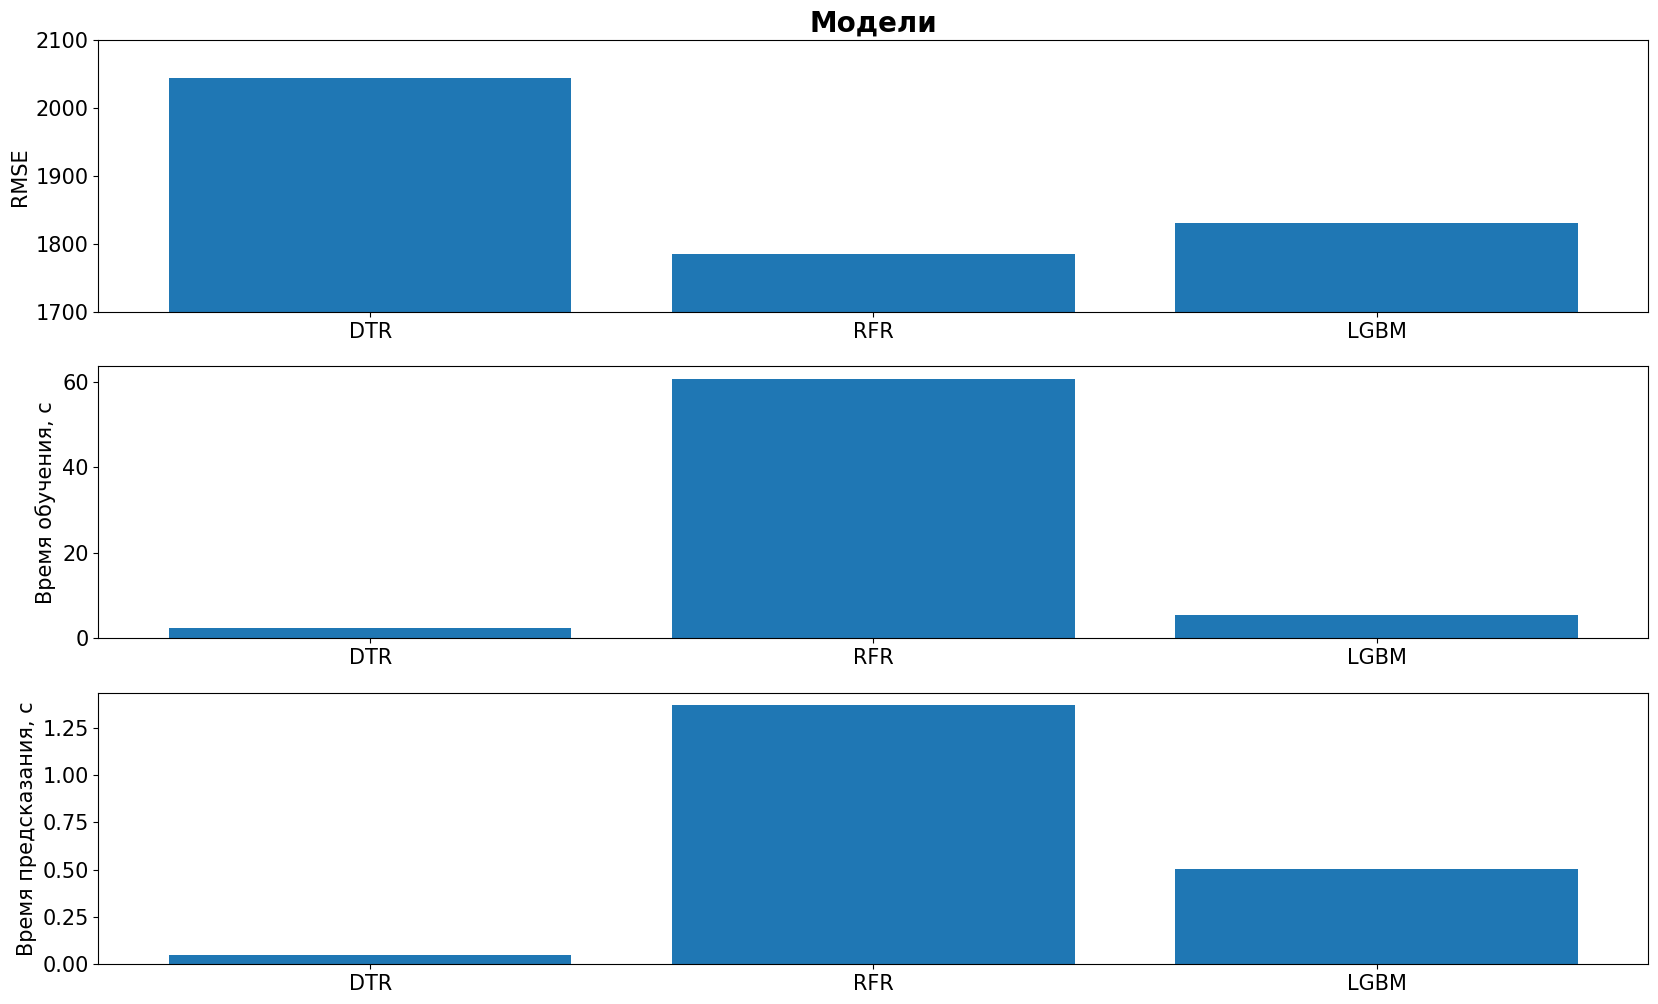

In [36]:
data_for_graph_score = {}
data_for_graph_fitting_time = {}
data_for_graph_prediction_time = {}

for result in results:
    data_for_graph_score[str(result[0])] = result[3]
    data_for_graph_fitting_time[str(result[0])] = result[4]
    data_for_graph_prediction_time[str(result[0])] = result[5]

data_for_graph_score = pd.Series(data_for_graph_score)
data_for_graph_fitting_time = pd.Series(data_for_graph_fitting_time)
data_for_graph_prediction_time = pd.Series(data_for_graph_prediction_time)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
ax1.set_title('Модели', fontsize=20, weight='bold')
ax1.set_ylabel('RMSE', fontsize=15)
ax2.set_ylabel('Время обучения, с', fontsize=15)
ax3.set_ylabel('Время предсказания, с', fontsize=15)
ax1.set_ylim(1700, 2100)
ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax3.tick_params(axis='both', labelsize=15)
ax1.bar(data_for_graph_score.index, data_for_graph_score.values)
ax2.bar(data_for_graph_fitting_time.index, data_for_graph_fitting_time.values)
ax3.bar(data_for_graph_prediction_time.index, data_for_graph_prediction_time.values)
plt.show();

Как видно из графиков RFR хоть и выигрывает немного по точности, но по скоростным параметрам отстаёт от LGBM.

Проведем выбор лучшей модели по основному параметру (RMSE):


In [37]:
best_model_name = None
best_model = None
best_params = None
best_result = float('inf')

for result in results:
    if result[3] < best_result:
        best_model_name = result[0]
        best_model = result[1]
        best_params = result[2]
        best_result = result[3]

display(f'Лучшая модель: {best_model_name}, {best_params}')
display(f'RMSE лучшей модели: {best_result:0.2f}')

"Лучшая модель: RFR, {'model__max_depth': 16, 'model__n_estimators': 43}"

'RMSE лучшей модели: 1785.64'

## Итоговое тестирование

Заново обучим модель на всей тренировочной выборке:

In [38]:
pipe = best_model
display(pipe)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=16, n_estimators=43,
                                       random_state=777))])

In [39]:
%%time
# Запускаем обучение
pipe.fit(X_train_encoded, y_train)

CPU times: total: 42 s
Wall time: 42.2 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=16, n_estimators=43,
                                       random_state=777))])

Преобразуем X_test при помощи target_encoder:

In [40]:
X_test_encoded = target_encoder.transform(X_test)

Сделаем расчёт предсказания:

In [41]:
%%time
y_predicted = pipe.predict(X_test_encoded)

CPU times: total: 938 ms
Wall time: 925 ms


Посчитаем итоговую оценку:

In [42]:
rmse_score = mean_squared_error(y_test, y_predicted, squared=False)
display(f'Итоговый RMSE: {rmse_score:.2f}')

'Итоговый RMSE: 1748.78'

Так как критерий для заказчика не один, посмотрим на аналогичные результаты для LGBM:

In [43]:
for result in results:
    if result[0] == 'LGBM':
        pipe = result[1]

Запускаем обучение:

In [44]:
%%time
pipe.fit(X_train_encoded, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=197, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=197
[LightGBM] [Warning] min_data_in_leaf is set=197, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 283492, number of used features: 10
[LightGBM] [Info] Start training from score 4418.052569
CPU times: total: 4.2 s
Wall time: 2.23 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=41, min_data_in_leaf=197,
                               num_leaves=49, random_state=777))])

Сделаем расчёт предсказания:

In [45]:
%%time
y_predicted = pipe.predict(X_test_encoded)

[LightGBM] [Warning] min_data_in_leaf is set=197, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=197
CPU times: total: 844 ms
Wall time: 439 ms


Посчитаем итоговую оценку:

In [46]:
rmse_score = mean_squared_error(y_test, y_predicted, squared=False)
display(f'Итоговый RMSE: {rmse_score:.2f}')

'Итоговый RMSE: 1813.91'

## Общие выводы

* Загружены и изучены данные сервиса по продаже автомобилей. Информация включает данные об анкетах на сайте продажи авто и об автомобилях, которые были выставлены на продажу.
* Данные содержали в небольшом количестве прямые и непрямые дубли, которые были либо удалены, либо обработаны.
* Обнаружена существенная доля пропусков по некоторым столбцам.
* В достаточно большом количестве в данных присутствовали ошибочные значения (нереалистичные данные по постановке на учёт и по мощности авто). Они были вычищены.
* Из данных удален ряд неинформативных столбцов (даты скачивания и создания анкеты, почтовый индекс, время посещения и количество фотографий).
* Данные подготовлены для обучения. Заполнены пропуски, категориальные переменные переведены в числовые методом target encoding.
* Исследованы три типа моделей DTR, RFR и LGBM. Для каждой модели подобраны лучшие параметры. Лучшие результаты по метрике RMSE показала модель RFR с параметрами max_depth=16 и n_estimators=43.
* На тестовой выборке результаты этой модели: RMSE ~ 1750, время обучения около 22 секунд, время расчёта предсказания ~600 мс.
* Для сравнения результаты LGBM: RMSE ~ 1810, время обучения около 1 секунд, время расчёта предсказания менее 150 мс.
* **Таким образом в случае если у точности наибольший приоритет для клиента рекомендуется использовать модель RFR с обозначенными выше параметрами. Однако, если время обучения и получения предсказания имеет больший вес, - имеет смысл взять на вооружение LGBM, которая так же дает неплохую точность, но работает значительно быстрее. Итоговые метрики точности для обеих моделей не превышают целевые 2500 RMSE.**